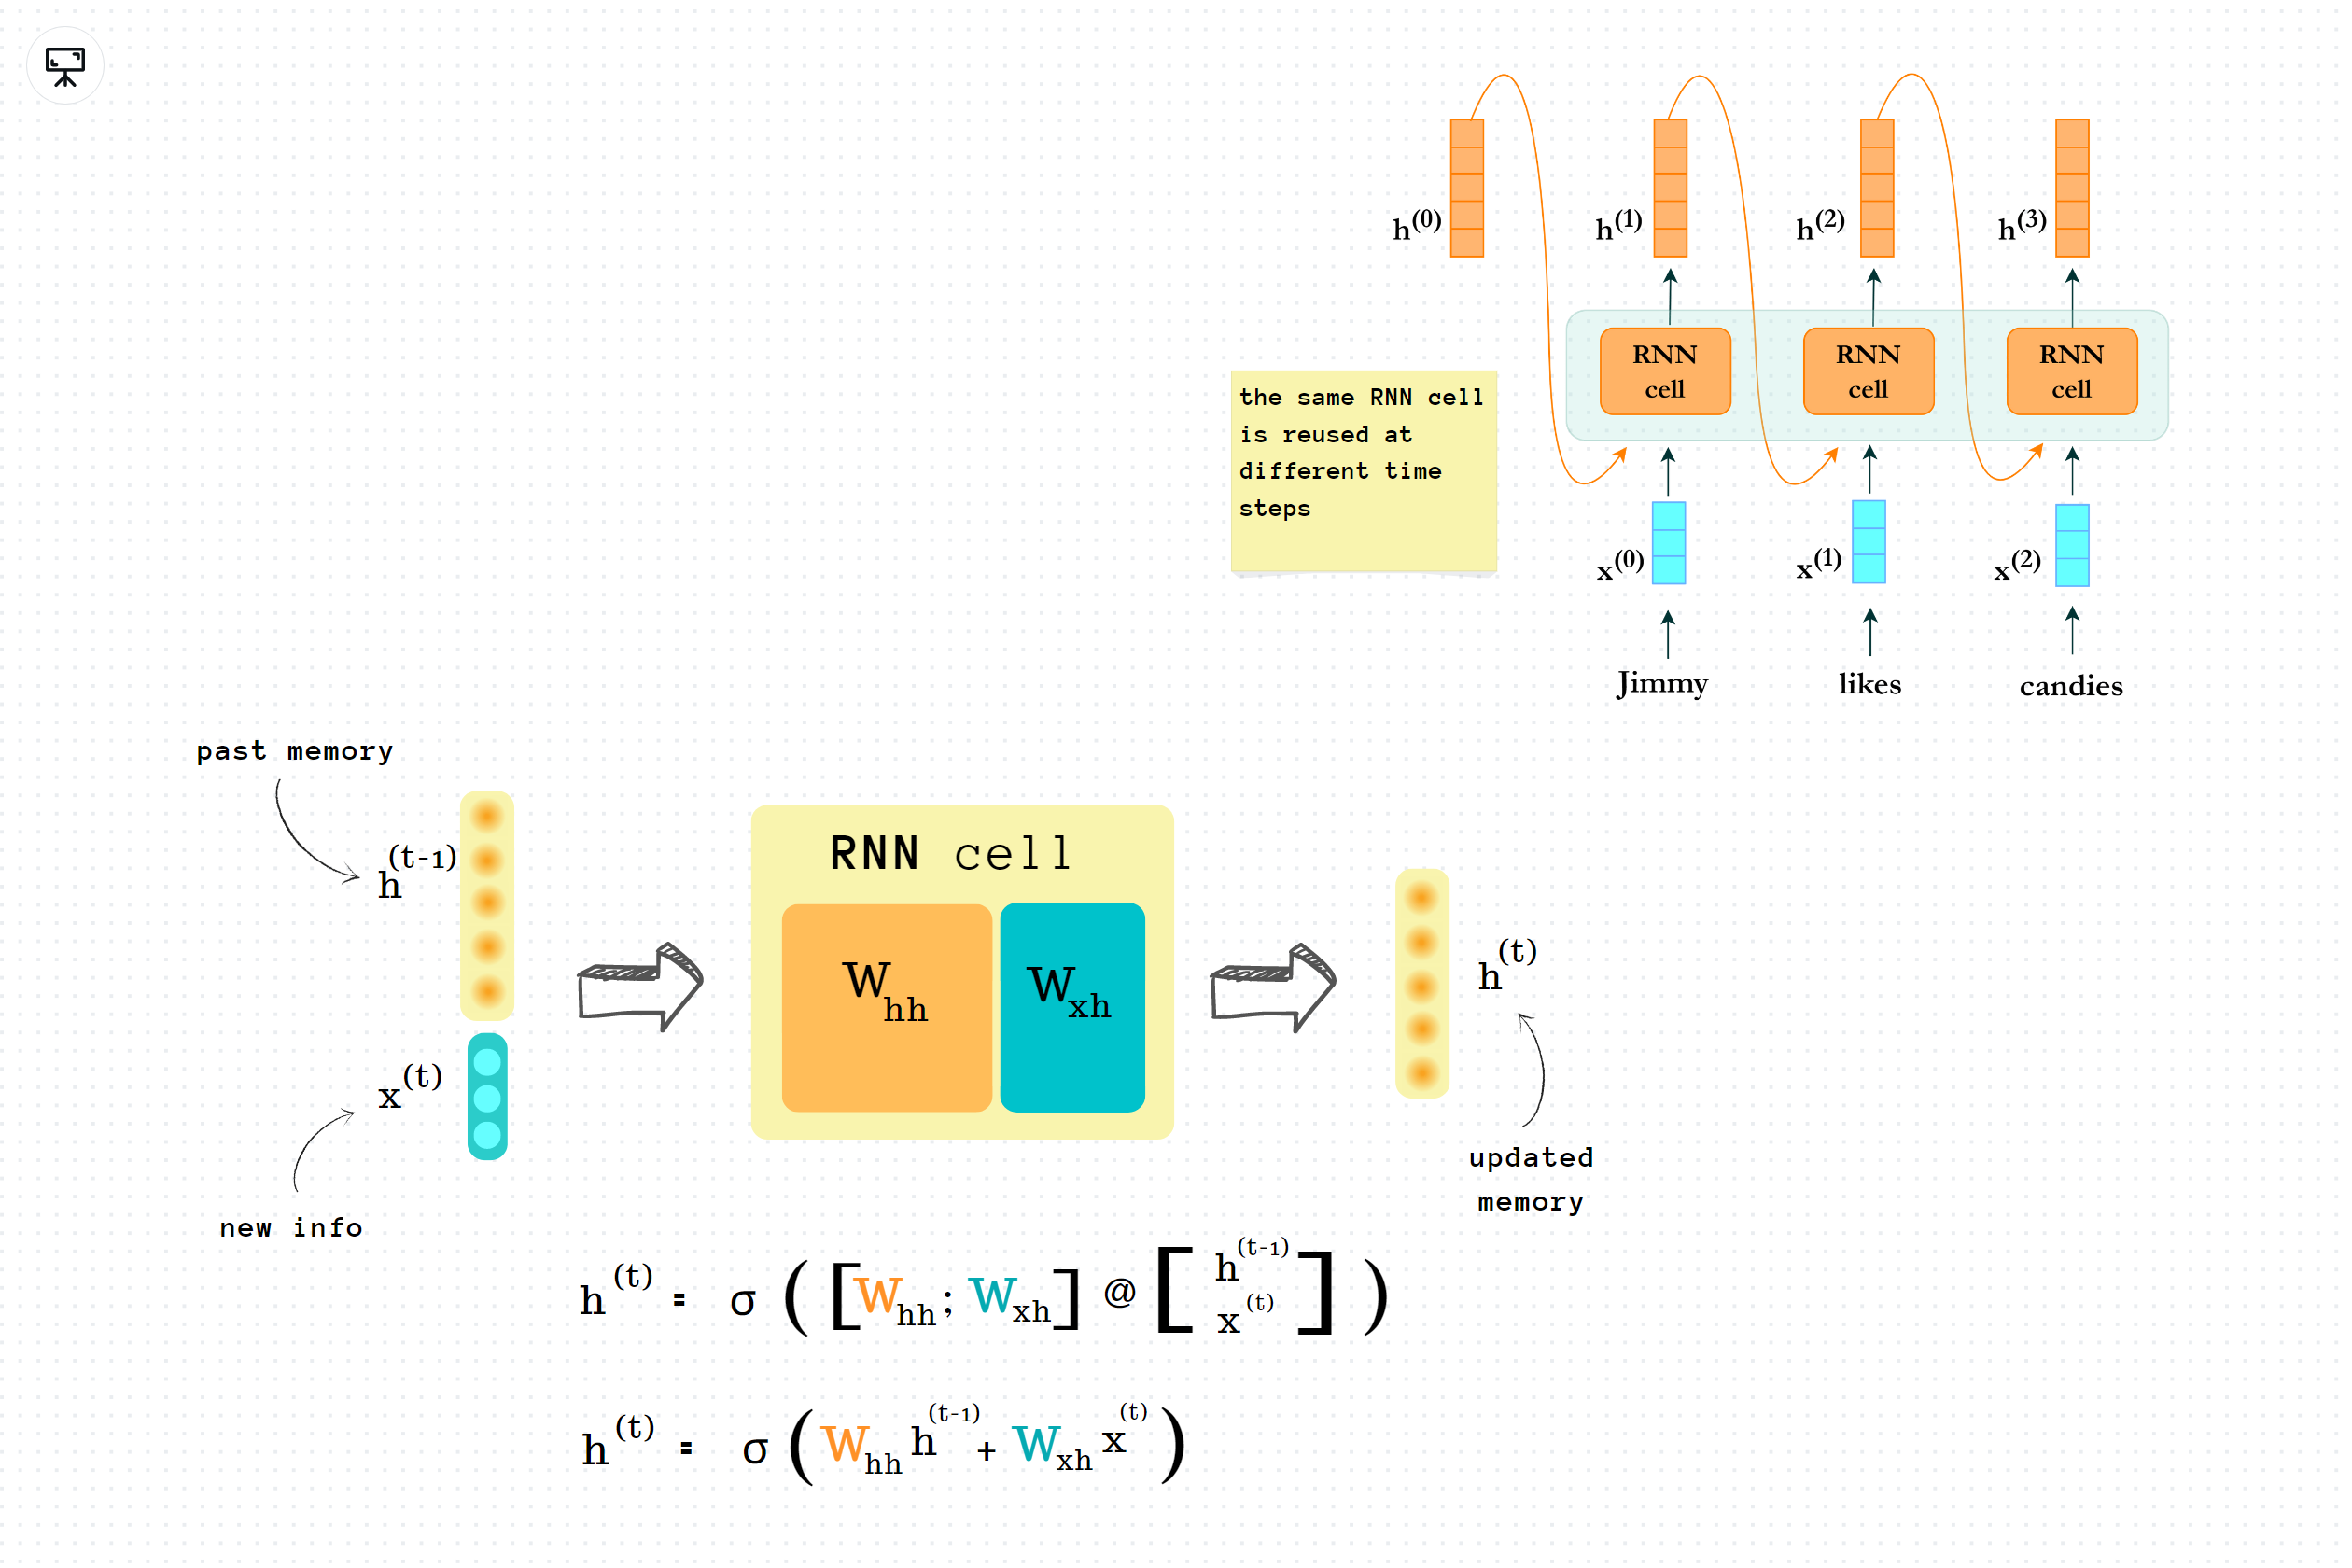

In [181]:
sentence = "Jimmy likes candies"
vocabulary = {"Jimmy":0, "likes":1, "candies":2}
indices = torch.LongTensor([vocabulary[word] for word in sentence.split()]) 
embedding_layer = nn.Embedding(num_embeddings = len(indices), embedding_dim=3)
sequence = embedding_layer(indices)
sequence.size()

torch.Size([3, 3])

## <h6 style="text-align: center;"><b>Initialize Recurrent Layer</b>

In [186]:
import torch.nn as nn

rnn_layer = nn.RNN(input_size = 3,               # dimentionality of input tensor 
                   hidden_size = 5,              # number of features in the hidden state h
                   batch_first = True)           # input/output size: (batch_size, seq_len, nfeature) 

W_hh = rnn_layer.weight_hh_l0
W_xh = rnn_layer.weight_ih_l0
bias_hh = rnn_layer.bias_hh_l0
bias_xh = rnn_layer.bias_ih_l0

print("W_hh shape", W_hh.size())
print("W_xh shape", W_xh.size())
print("bias_xh shape", bias_xh.size())
print("bias_hh shape", bias_hh.size())

W_hh shape torch.Size([5, 5])
W_xh shape torch.Size([5, 3])
bias_xh shape torch.Size([5])
bias_hh shape torch.Size([5])


In [191]:
# create initial hidden state 
hidden_zero = torch.zeros(1, hidden_size) # h0

In [194]:
# compute sequence representation with RNN
rnn_output, last_hidden = rnn_layer(sequence, hidden_zero)

print(f"RNN output with size {rnn_output.size()}:\n")
for t, h_t in enumerate(rnn_output.detach()):
    print(f"      h{t+1}: ", h_t)
print()
print(f"RNN last hidden state with size {last_hidden.size()}: \n")
print(f"      h3: ", last_hidden.detach())

RNN output with size torch.Size([3, 5]):

      h1:  tensor([-0.2300, -0.0228, -0.1992, -0.6265,  0.7860])
      h2:  tensor([-0.3477,  0.2743, -0.3677, -0.6379, -0.1411])
      h3:  tensor([-0.4269,  0.3540, -0.4831,  0.2662,  0.5106])

RNN last hidden state with size torch.Size([1, 5]): 

      h3:  tensor([[-0.4269,  0.3540, -0.4831,  0.2662,  0.5106]])


## <h6 style="text-align: center;"><b>Manual forward RNN Layer</b>

In [195]:
outputs = []

for t, word in enumerate(sequence):
    xt = word.view(1, -1)  #  (embed_dim) -> (1, embed_dim)
    
    print(f"Time step {t} =>")
    print(f"Input word ({sentence.split()[t]}) :", xt.detach().numpy())
    if t > 0:
        prev_h = outputs[-1]
    else:
        prev_h = hidden_zero
        
    # ((1, 3) @ (3, 5) + (1, 5)) + ((1, 3) @ (3, 5) + (1, 5))
    ht = torch.tanh((xt @ W_xh.T + bias_xh) + (prev_h @ W_hh.T + bias_hh))
    print("RNN output: ", ht.detach().numpy())
    outputs.append(ht.detach())

Time step 0 =>
Input word (Jimmy) : [[ 2.211885    0.76813054 -0.7700994 ]]
RNN output:  [[-0.22997004 -0.0227976  -0.19916259 -0.62652695  0.7859915 ]]
Time step 1 =>
Input word (likes) : [[-0.11693516  0.89210695 -0.3381058 ]]
RNN output:  [[-0.34771317  0.27426186 -0.36773136 -0.63794255 -0.14113191]]
Time step 2 =>
Input word (candies) : [[-0.66406673  1.7353394   1.3459151 ]]
RNN output:  [[-0.42691988  0.35397598 -0.48305735  0.26618958  0.51064885]]


## <h3 style="text-align: center;"><b>Sequence classification</b>

Build RNN sequence model to classify Yelp restaurant reviews as positive or negative.

In [204]:
# import datasets
yelp = pd.read_csv(r"C:\Users\HUAWEI\Downloads\reviews_with_splits_lite.csv")
yelp.head()

,rating,review,split
0,negative,terrible place to work for i just heard a stor...,train
1,negative,"hours , minutes total time for an extremely s...",train
2,negative,my less than stellar review is for service . w...,train
3,negative,i m granting one star because there s no way t...,train
4,negative,the food here is mediocre at best . i went aft...,train


In [205]:
yelp.split.value_counts()

train    39200
val       8400
test      8400
Name: split, dtype: int64

In [206]:
train_dataset = yelp[yelp.split=="train"]
valid_dataset = yelp[yelp.split=="val"]
test_dataset = yelp[yelp.split=="test"]

## <h6 style="text-align: center;"><b>Prepare data for training RNN</b>

1. build a vocabulary mapping unique tokens into integers
2. create a Dataset class to access vectorized training examples
3. group and pad training examples into minibatches for efficient training

In [210]:
import re
from torchtext.vocab import vocab
from collections import Counter, OrderedDict, defaultdict

## <h6 style="text-align: center;"><b>STEP 1. Build vocabularies</b>

In [235]:
def tokenize(text):
    clean_text = re.sub("[\W]+", " ", text.lower().replace("-", " "))
    return clean_text.split()

In [291]:
token_counter = Counter()
for index, row in train_dataset.iterrows():
    label, review = row.rating, row.review
    tokens = tokenize(review)
    token_counter.update(tokens)
    
sorted_tuples = token_counter.most_common()
vocabulary = vocab(OrderedDict(sorted_tuples), min_freq=2, specials = ["<pad>", "<unk>", "<bos>", "<eos>"])
pad_index = vocabulary["<pad>"]
unk_index = vocabulary["<unk>"]
vocabulary.set_default_index(unk_index) # tokens not seen in training data will be assigned 1 by default
len(vocabulary)

30931

* **\<unk\>**  is a reserved token for Out-Of-Vocabulary words, that did not occur in the training dataset
* **\<pad\>** serves as a placeholder for adjusting the length of shorter sequences when batching sequences together
* **\<bos\>** and **\<eos\>** are helpful in sequence modeling to indicate sentence boundaries to the model

In [279]:
# Illustrating the usage of vocabulary to convert words into indices

print([vocabulary[token] for token in "i found the plot intriguing".split()])

[6, 246, 4, 17903, 13943]


Create a dictionary mapping for labels too.

In [250]:
label2index = {label: index for index, label in enumerate(list(train_dataset.rating.unique()))}
label2index

{'negative': 0, 'positive': 1}

## <h6 style="text-align: center;"><b>STEP 2. Vectorize sequences</b>

Create a class to allow an easy access to training examples.

In [280]:
class CustomDataset(Dataset):
    
    """ Converts sequences of words into sequences of integers, 
        and labels of negative and positive into 0 and 1. """
    
    def __init__(self, dataframe, vocabulary, label2index):
        self.data = dataframe
        self.voc = vocabulary
        self.lab2idx = label2index
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        row = self.data.iloc[index]
        review, label = row.review, row.rating
        vectorized_review = [self.voc[token] for token in tokenize(row.review)]
        label_index = self.lab2idx[label]
        
        return torch.LongTensor(vectorized_review), label_index

In [288]:
training_data = CustomDataset(train_dataset, vocabulary, label2index)
validation_data = CustomDataset(valid_dataset, vocabulary, label2index)

print("Review:\n", train_dataset.iloc[1].review)
print("Vectorized review:\n", training_data[1][0], "\nlabel id:", training_data[1][1])

Review:
  hours , minutes total time for an extremely simple physical . stay away unless you have hours to waste ! ! ! 

Vectorized review:
 tensor([   2,  341,  135,  735,   51,   12,   66,  490,  670, 3880,  422,  225,
         743,   20,   26,  341,    7,  850,    3]) 
label id: 0


## <h6 style="text-align: center;"><b>STEP 3. Pad and Batchify</b>

To store a batch of sequences in a tensor, we need to make sure that all sequences in a batch are of the same length.\
PyTorch provides ``pad_sequence()`` method to pad shorter sequences to the length of the longest sequence in a batch.\
We can apply further preprocessing (like padding) of sequences that are collected in a batch inside ``collate_batch`` function.\
The function will be used by dataloader to collate training examples into batches.

In [335]:
def collate_batch(list_samples):
    
    seq_list, label_list, seq_lengths = [], [], []
    for sequence, label in list_samples:
        seq_list.append(sequence)
        seq_lengths.append(len(sequence))
        label_list.append(label)
        
    label_list = torch.tensor(label_list).float()
    seq_lengths = torch.tensor(seq_lengths)
    padded_sequences = nn.utils.rnn.pad_sequence(seq_list, batch_first=True)
    return padded_sequences, seq_lengths, label_list

In [337]:
# Illustrating how padding works

dataloader = DataLoader(training_data, shuffle=True, batch_size = 4, collate_fn=collate_batch)
seq_batch, len_batch, label_batch = next(iter(dataloader))
seq_batch, len_batch, label_batch

(tensor([[    2,     4,   365,  ...,     0,     0,     0],
         [    2,     6,   299,  ...,     0,     0,     0],
         [    2,    24,   116,  ...,     0,     0,     0],
         [    2,  1459,    19,  ..., 15254,  1013,     3]]),
 tensor([120, 123, 256, 377]),
 tensor([0., 1., 1., 0.]))

In [338]:
batch_size = 32
train_dl = DataLoader(training_data, shuffle=True, batch_size=batch_size, collate_fn=collate_batch)
valid_dl = DataLoader(validation_data, shuffle=False, batch_size=batch_size, collate_fn=collate_batch)

Now the data is ready for an RNN model!

## <h6 style="text-align: center;"><b>Building RNN model</b>

* **embedding layer** embeds each word index into a feature vector of dimensionality equal to embed_dim
* **recurrent layer** produces sequence representation, encoded in the final hidden state
* **fully connected layer** returns a single output value as the model prediction

In [331]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.rnn = nn.GRU(embed_dim, rnn_hidden_size, batch_first=True)
        self.fc1 = nn.Linear(rnn_hidden_size, fc_hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc_hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, seq_batch, seq_lengths):
        emb = self.embedding(seq_batch)
        
        # packed_sequences shape: (batch_size*seq_len, embed_dim)
        packed_sequences = nn.utils.rnn.pack_padded_sequence(emb,
                                                             seq_lengths.cpu().numpy(),
                                                             enforce_sorted=False,
                                                             batch_first=True)
        
        # rnn_hiddens is PackedSequence .data shape:(batch_size*seq_len, hidden_size)
        # last_hidden shape: (1, batch_size, hidden_size)
        rnn_hiddens, last_hidden = self.rnn(packed_sequences)
        
        # output shape: (1, batch_size, hidden_dim)
        output = self.relu(self.fc1(last_hidden))
        # output shape: (1, batch_size, 1)
        output = self.sigmoid(self.fc2(output))
        return output.view(-1)

In [339]:
vocab_size = len(vocabulary)
embed_dim = 20
rnn_hidden_size = 64
fc_hidden_size = 64

torch.manual_seed(1)
model = RNN(vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size)
model

RNN(
  (embedding): Embedding(30931, 20, padding_idx=0)
  (rnn): GRU(20, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [333]:
def train(dataloader):
    model.train()
    epoch_acc, epoch_loss = 0, 0
    for seq_batch, seq_lengths, label_batch in dataloader:
        # step 1. remove  current gradients
        optimizer.zero_grad()
        # step 2. predict the probability of label 1:positive
        prediction = model(seq_batch, seq_lengths) 
        # step 3. compute prediction error
        loss = loss_function(prediction, label_batch)
        # step 4. compute gradients
        loss.backward()
        # step 5. update model parameters
        optimizer.step()
        # step 6.reporting
        epoch_loss += loss.item()*label_batch.size(0)
        epoch_acc += ((prediction >= 0.5).float() == label_batch).float().sum().item()
    return epoch_loss/len(dataloader.dataset), epoch_acc/len(dataloader.dataset)

def evaluate(dataloader):
    model.eval()
    epoch_acc, epoch_loss = 0, 0
    with torch.no_grad():
        for seq_batch, seq_lengths, label_batch in dataloader:
            prediction = model(seq_batch, seq_lengths) 
            loss = loss_function(prediction, label_batch)
            epoch_loss += loss.item()*label_batch.size(0)
            epoch_acc += ((prediction >= 0.5).float() == label_batch).float().sum().item()
    return epoch_loss/len(dataloader.dataset), epoch_acc/len(dataloader.dataset)

Given that the model output is the probability of class 1 (positive), we use the binary cross-entropy loss function.

In [329]:
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
## <h6 style="text-align: center;"><b>Training RNN model</b>

In [340]:
num_epochs = 10
torch.manual_seed(1)
for epoch in range(num_epochs):
    loss_train, acc_train = train(train_dl)
    loss_valid, acc_valid = train(valid_dl)
    print(f"Epoch {epoch} accuracy: {acc_train}"
          f"val_accuracy: {acc_valid}")

KeyboardInterrupt: 

In [ ]:
acc_test, _  = evaluate(test_dl)
print(f"test_accuracy: {acc_valid}")

In [2]:
import pandas as pd
# Read raw data
surnames = pd.read_csv(r"C:\Users\HUAWEI\Downloads\surnames_with_splits.csv", header=0)
surnames.head()

,nationality,nationality_index,split,surname
0,Arabic,15,train,Totah
1,Arabic,15,train,Abboud
2,Arabic,15,train,Fakhoury
3,Arabic,15,train,Srour
4,Arabic,15,train,Sayegh


In [11]:
short_df = list(surnames.nationality.value_counts()[surnames.nationality.value_counts()>200].keys())

In [14]:
surnames[surnames.nationality.isin(short_df)].split.value_counts()

train    7176
test     1546
val      1534
Name: split, dtype: int64

In [15]:
small_surnames = surnames[surnames.nationality.isin(short_df)]

In [86]:
training = small_surnames[small_surnames.split=="train"]
validation = small_surnames[small_surnames.split=="valid"]
testing = small_surnames[small_surnames.split=="test"]

In [26]:
from torch.utils.data import DataLoader, Dataset

In [33]:
from collections import Counter, defaultdict, OrderedDict
import torch
from torchtext.vocab import vocab

# build vocabulary from training data
char_counter = Counter()
for _, row in train_data.iterrows():
    char_counter.update(row.surname)
    
sorted_chars = char_counter.most_common()
vocabulary = vocab(OrderedDict(sorted_chars), specials=["<pad>", "<unk>", "<bos>", "<eos>"])
unk_index = vocabulary["<unk>"]
vocabulary.set_default_index(unk_index)

# build orinationalities mapping
nationalities = sorted(train_data.nationality.unique())
nation2idx = dict(zip(nationalities, range(len(nationalities))))

In [36]:
def vectorize(text):
    tokens = [vocabulary["<bos>"]]
    tokens.extend(vocabulary[char] for char in text)
    tokens.append(vocabulary["<eos>"])
    
    input_sequence = torch.tensor(tokens[:-1]).long()
    output_sequence = torch.tensor(tokens[1:]).long()
    
    return input_sequence, output_sequence, len(tokens)

In [76]:
class CustomDataset(Dataset):
    
    def __init__(self, surname_df, vocabulary, nation2idx):
        self.df = surname_df
        self.voc = vocabulary
        self.nat2idx = nation2idx
        self.idx2nat = {idx:nation for nation, idx in nation2idx.items()}
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        row = self.df.iloc[index]
        nationality, surname = row.nationality, row.surname
        input_tensor, output_tensor, length = vectorize(surname)
        nationality_index = self.nat2idx[nationality]
        
        return {"x": input_tensor,
                "y": output_tensor,
                "nation": nationality_index}
        

In [87]:
train_data = CustomDataset(training, vocabulary, nation2idx)
valid_data = CustomDataset(validation, vocabulary, nation2idx)

In [88]:
train_data[9]

{'x': tensor([ 2, 24,  8, 13,  6, 14,  8]),
 'y': tensor([24,  8, 13,  6, 14,  8,  3]),
 'nation': 0}

In [43]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence, pad_packed_sequence

In [79]:
# Group and pad sequences

def collate_batch(list_of_samples):
    inputs, outputs, lengths, nations = [],[],[],[]
    for sample in list_of_samples:
        inputs.append(sample["x"])
        outputs.append(sample["y"])
        lengths.append(len(sample["x"]))
        nations.append(sample["nation"])
        
    padded_x = pad_sequence(inputs, batch_first=True, padding_value = vocabulary["<pad>"])
    padded_y = pad_sequence(outputs, batch_first=True, padding_value = vocabulary["<pad>"])
    return {
        "inputs": padded_x,
        "targets": padded_y,
        "lengths": torch.tensor(lengths, dtype=torch.int32),
        "nations": torch.tensor(nations, dtype=torch.int32)
    }

In [89]:
dataloader = DataLoader(train_data, batch_size=4, collate_fn=collate_batch, shuffle=True, drop_last=True)

In [90]:
next(iter(dataloader))

{'inputs': tensor([[ 2, 49,  4, 15, 14,  8,  7, 20, 12,  5, 17],
         [ 2, 24, 10, 12, 16,  6, 33,  8,  0,  0,  0],
         [ 2, 41,  5, 11, 16, 13,  0,  0,  0,  0,  0],
         [ 2, 24,  8, 13,  4,  9,  0,  0,  0,  0,  0]]),
 'targets': tensor([[49,  4, 15, 14,  8,  7, 20, 12,  5, 17,  3],
         [24, 10, 12, 16,  6, 33,  8,  3,  0,  0,  0],
         [41,  5, 11, 16, 13,  3,  0,  0,  0,  0,  0],
         [24,  8, 13,  4,  9,  3,  0,  0,  0,  0,  0]]),
 'lengths': tensor([11,  8,  6,  6], dtype=torch.int32),
 'nations': tensor([9, 4, 6, 0], dtype=torch.int32)}

In [91]:
class GeneratorModel(nn.Module):
    def __init__(self, embedding_size, num_nationalities, rnn_hidden_size, vocab_size, dropout_prob=0.2):
        super().__init__()
        self.char_embeddings = nn.Embedding(num_embeddings=vocab_size,
                                      embedding_dim=embedding_size,
                                      padding_idx=vocabulary["<pad>"])
        
        self.nation_embeddings = nn.Embedding(num_embeddings=num_nationalities,
                                      embedding_dim=rnn_hidden_size)
        
        self.gru = nn.GRU(input_size=embedding_size, 
                         hidden_size=rnn_hidden_size,
                         batch_first=True)
        
        self.fc = nn.Linear(in_features=rnn_hidden_size, 
                            out_features=vocab_size)
        
        self.dropout = nn.Dropout(dropout_prob)
        
    def forward(self, seq_tensor, seq_lengths, nations):
        # inputs.size [batch_size, max_seq_len]
        
        emb_seq = self.char_embeddings(seq_tensor)
        emb_nation = self.nation_embeddings(nations).unsqueeze(0)
        
        packed_seq = pack_padded_sequence(emb_seq,  seq_lengths.cpu().numpy(), enforce_sorted=False, batch_first=True)
        
        gru_output, gru_last_hidden = self.gru(packed_seq, emb_nation)
        
        output, sizes = pad_packed_sequence(gru_output, batch_first=True)
        
        output = self.dropout(output)
        
        logits = self.fc(output)
        
        return logits
    
token_emb_size = 64
rnn_hidden_size = 64
num_nationalities = len(nationalities)
model = GeneratorModel(vocab_size=len(vocabulary),
                       num_nationalities=num_nationalities,
                       embedding_size=token_emb_size,
                       rnn_hidden_size=rnn_hidden_size)
model

GeneratorModel(
  (char_embeddings): Embedding(75, 64, padding_idx=0)
  (nation_embeddings): Embedding(11, 64)
  (gru): GRU(64, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=75, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [83]:
sample = next(iter(dataloader))
model(sample["inputs"], sample["lengths"], sample["nations"]).size()

torch.Size([4, 9, 75])

In [92]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

batch_size = 64
PAD_IDX = vocabulary["<pad>"]
train_state = defaultdict(list)

optimizer = torch.optim.Adam(model.parameters())
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode = "min",factor = 0.5, patience = 2)

ce_loss = nn.CrossEntropyLoss(ignore_index = PAD_IDX)
num_epochs = 200

In [97]:
for epoch in range(num_epochs):
    
    running_loss = 0
    model.train()
    for batch_index, batch in enumerate(DataLoader(train_data,
                                                   collate_fn=collate_batch,
                                                   batch_size=batch_size, shuffle=True), 
                                       start=1):
        # step 0. zero gradients
        optimizer.zero_grad()
        
        # step 1. compute predictions
        y_pred = model(batch["inputs"], batch["lengths"], batch["nations"])
        
        # step 2. compute the loss
        y_pred = y_pred.contiguous().view(-1, len(vocabulary))
        loss = ce_loss(y_pred, batch["targets"].view(-1))
        
        # step 3. compute gradients
        loss.backward()
        
        # step 4. update parameters
        optimizer.step()
        
        # step 5. reporting
        batch_loss = loss.item()
        running_loss += (batch_loss - running_loss) / batch_index
        
    train_state['train_loss'].append(running_loss)
    
    if epoch % 20 == 0:
        print("Running loss: {};".format(running_loss))
        
    running_loss = 0     
    model.eval()
    for batch_index, batch in enumerate(DataLoader(valid_data,
                                                   collate_fn=collate_batch,
                                                   batch_size=batch_size, shuffle=True),
                                       start=1):   
        with torch.no_grad():
            # step 1. compute predictions
            y_pred = model(batch["inputs"], batch["lengths"], batch["nations"])

            # step 2. compute the loss
            y_pred = y_pred.contiguous().view(-1, len(vocabulary))
            loss = ce_loss(y_pred, batch["targets"].view(-1))
            
            # step 5. reporting
            batch_loss = loss.item()
            running_loss += (batch_loss - running_loss) / batch_index
            
    train_state['valid_loss'].append(running_loss)

Running loss: 3.203469510627003;


ValueError: num_samples should be a positive integer value, but got num_samples=0

In [98]:
getattr(nn,"GRU")

torch.nn.modules.rnn.GRU